In [1]:
dataset <- "ARPALombardia"
merging_datasets <- c(dataset, "SCIA")
state <- "Lombardia"
match_dist <- 10000
new_dataset <- "LOM"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/integrazioni_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Veneto", "Trentino-Alto Adige", "Emilia-Romagna"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db)
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"))


In [5]:
data |>
    filter((dataset == "ARPALombardia" & sensor_key == 189L) | (dataset == "SCIA" & sensor_key == 1851L), variable == -1L) |>
    pivot_wider(names_from = c(dataset, key), values_from = value, id_cols = date) |>
    mutate(delT = `SCIA_331` - `ARPALombardia_189`) |>
    filter(!is.na(delT))


# Source:   SQL [?? x 4]
# Database: DuckDB v0.9.2 [root@Darwin 23.2.0:R 4.3.2/:memory:]
   date       SCIA_331 ARPALombardia_189  delT
   <date>        <dbl>             <dbl> <dbl>
 1 2003-03-15      1.1               1.1 0    
 2 2003-03-19      0.4               0.4 0    
 3 2003-03-22      2.8               2.8 0    
 4 2003-03-26      2.8               2.8 0    
 5 2003-04-01     10                10   0    
 6 2003-04-03      5.8               5.7 0.100
 7 2003-04-20      7.7               7.7 0    
 8 2003-04-23      8.7               8.7 0    
 9 2003-05-12     13.8              13.8 0    
10 2003-05-25     14.1              14.1 0    
# i more rows

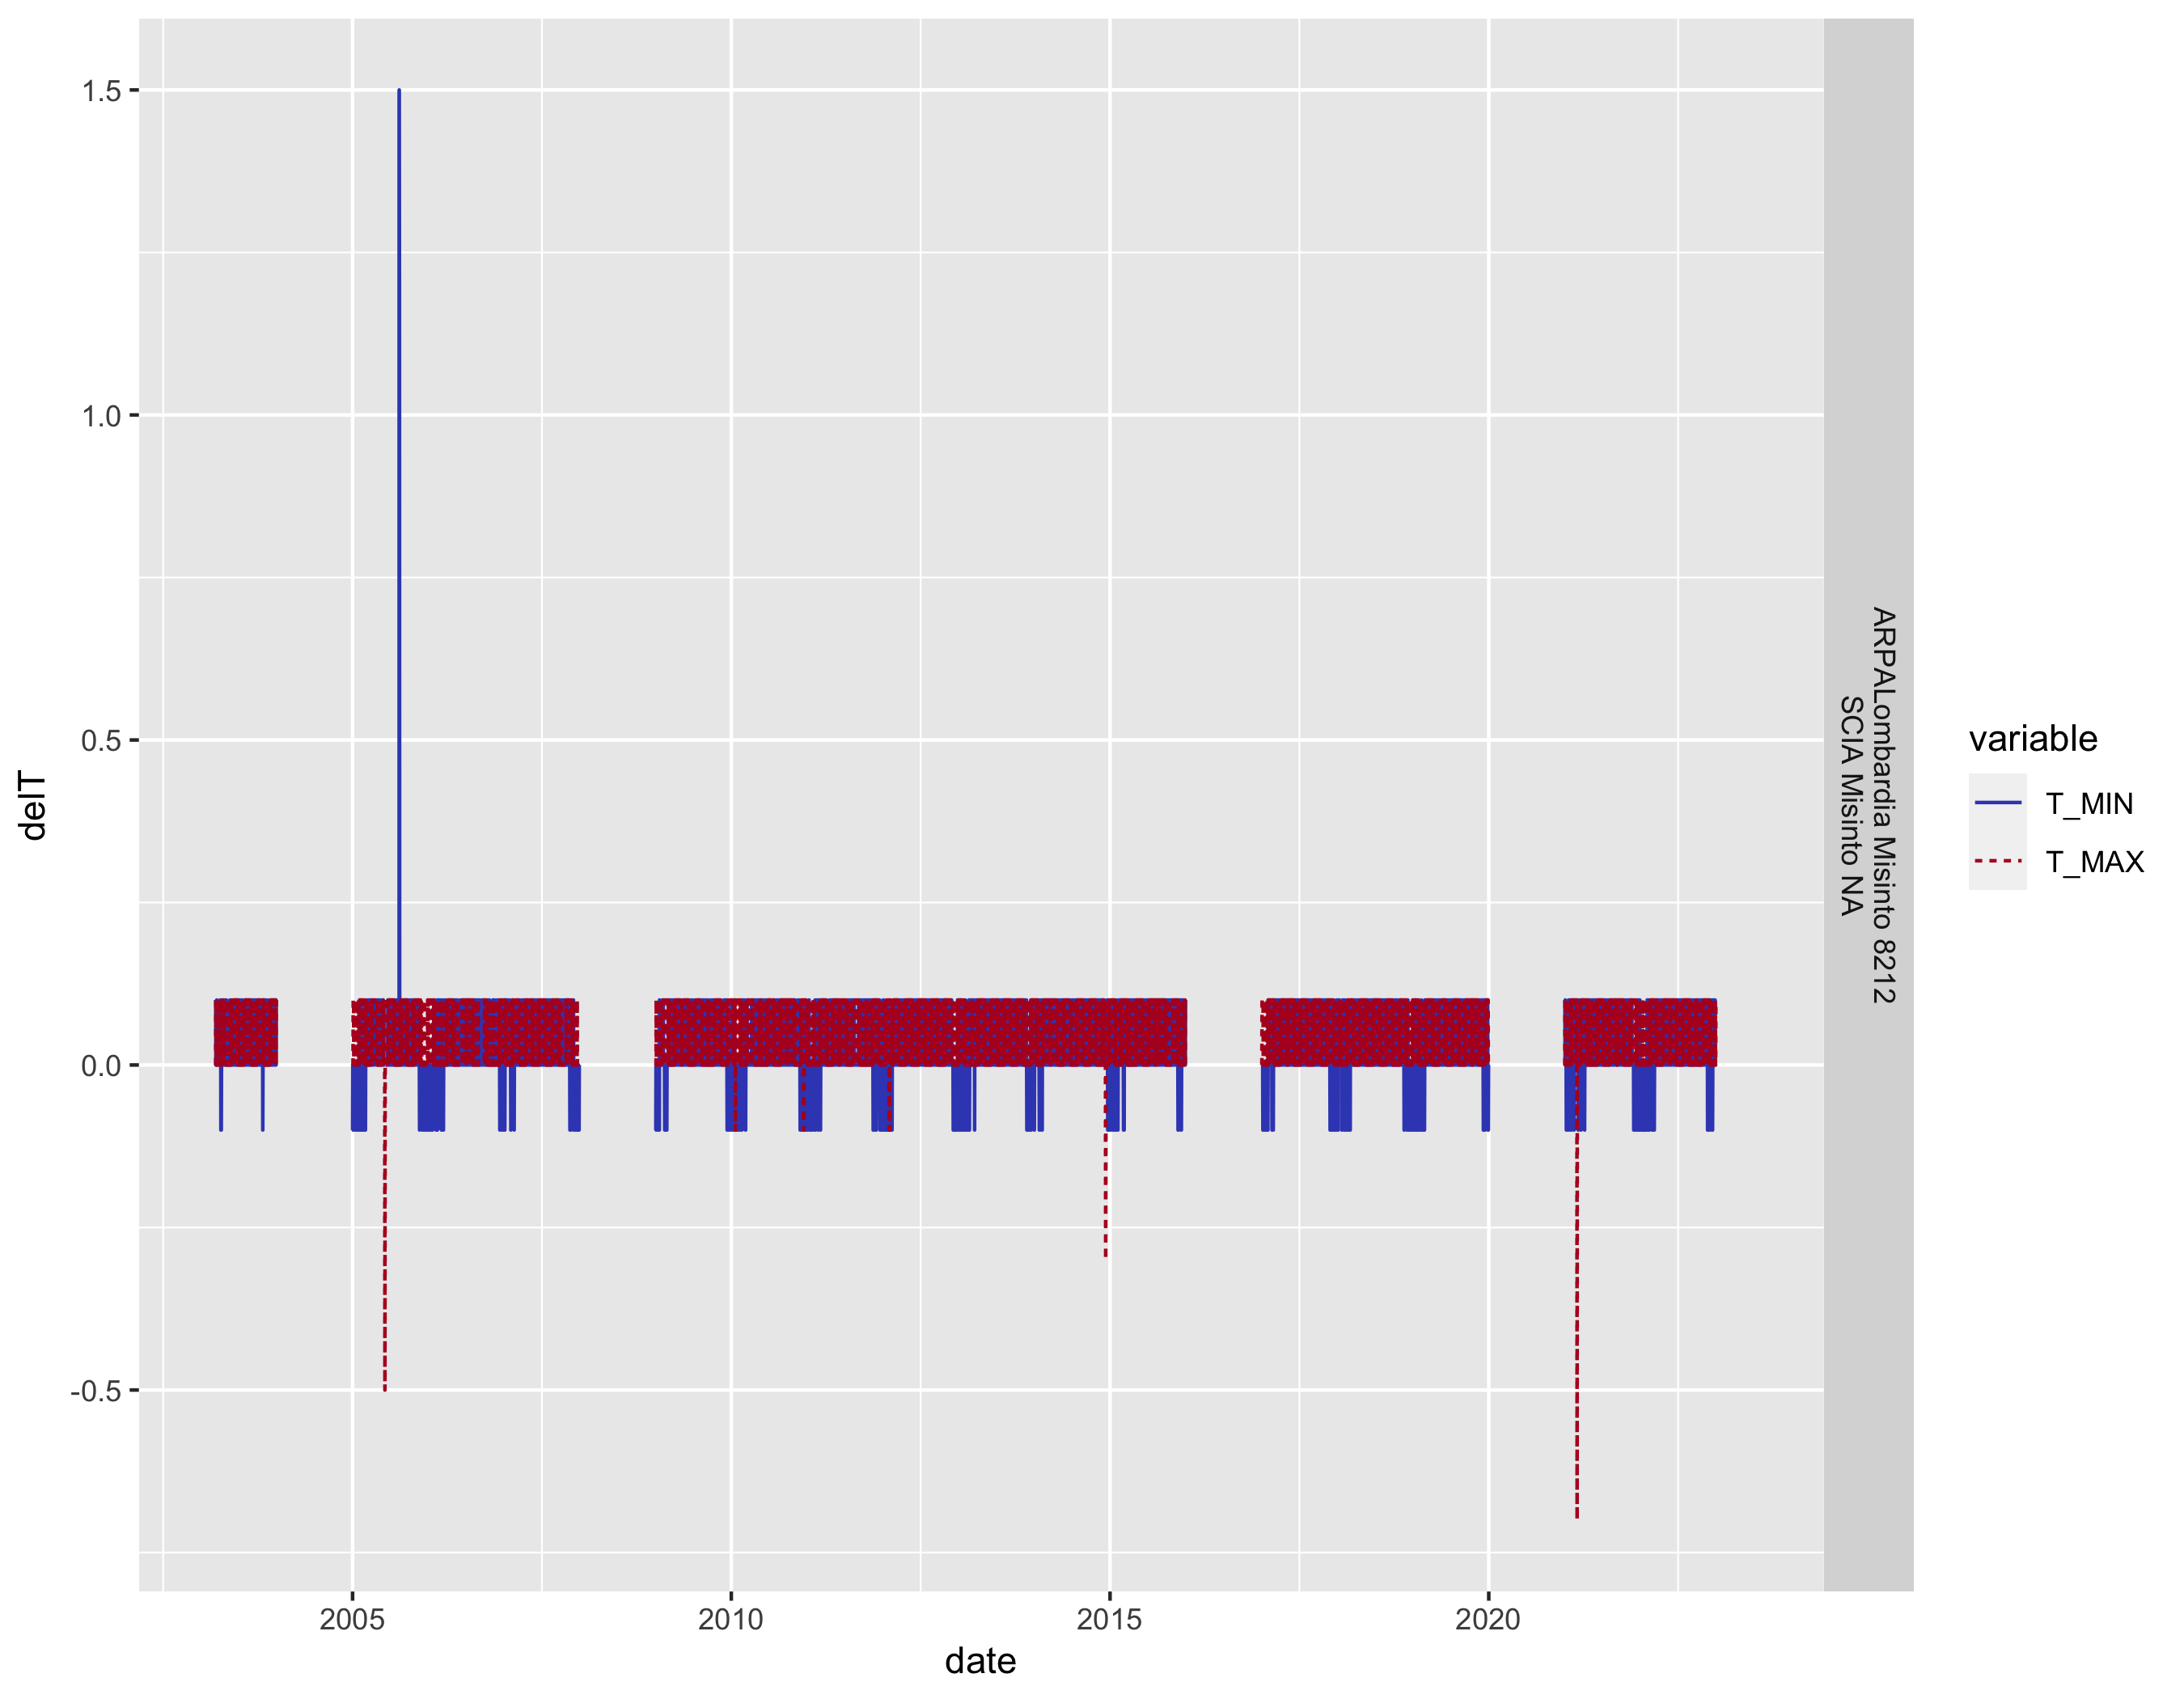

In [6]:
plot_diffs(analysis |> filter(sensor_key_x == 189L, sensor_key_y == 1851L), data)


In [7]:
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [ ]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 15L, 0.5)


In [ ]:
incomp |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset, sensor_key), by = c("key_y" = "key")) |>
    arrange(desc(abs(k0)))


In [ ]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, 1)
db <- merged_checkpoint(merge_results, metadata, new_dataset)
rm(merge_results)
gc()


In [ ]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt)
pd$plot + facet_grid(variable ~ .)


In [ ]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot + facet_grid(variable ~ .)


In [ ]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_availability_by_elevation(clim_availabilities, db$meta |> collect())
